In [1]:
import os, glob, shutil
import urllib.request as r
import kaggle 

def data_yuklab_olish(saqlash_uchun_papka, data_nomi = "lentils"): 
    
    data_nomlari = ["salaries", "exams", "college", "cars", "mall", "customers", "humanitarian", "apple_disease",
                    "rice_leaf_disease", "lentils", "brain", "fruits", "aeroscapes", "cardiac", "vehicles"]
    assert data_nomi in data_nomlari, f"Mavjud bo'lgan dataset {data_nomlari} dan birini kiriting!"
    
    if data_nomi == "rice_leaf_disease": url = "kaggle datasets download -d killa92/rice-leaf-disease-classification-dataset"
    elif data_nomi == "lentils": url = "kaggle datasets download -d killa92/lentils-classification-dataset"
    elif data_nomi == "aeroscapes": url = "kaggle datasets download -d killa92/aerospaces-semantic-segmentation-dataset"
    elif data_nomi == "cardiac": url = "kaggle datasets download -d killa92/cardiac-semantic-segmentation-dataset"
    elif data_nomi == "brain": url = "kaggle datasets download -d killa92/brain-ct-tumor-classification-dataset"
    elif data_nomi == "fruits": url = "kaggle datasets download -d killa92/fruits-classification-dataset"
    elif data_nomi == "apple_disease": url = "kaggle datasets download -d killa92/apple-disease-dataset"
    elif data_nomi == "vehicles": url = "kaggle datasets download -d killa92/vehicle-detection-dataset"
    
    # Download from the checkpoint path
    if os.path.isfile(f"{saqlash_uchun_papka}/{data_nomi}.csv") or os.path.isdir(f"{saqlash_uchun_papka}/{data_nomi}"): print(f"Dataset yuklab olingan. {saqlash_uchun_papka}/{data_nomi} papkasini ni tekshiring."); pass

    # If the checkpoint does not exist
    else: 
        ds_nomi = url.split("/")[-1]
        full_path = f"{saqlash_uchun_papka}/{ds_nomi}"
        print(f"{data_nomi} dataset yuklanmoqda...")
        # Download the dataset
        os.system(f"{url} -p {full_path}")
        shutil.unpack_archive(f"{full_path}/{ds_nomi}.zip", f"{saqlash_uchun_papka}/{ds_nomi}")
        os.remove(f"{full_path}/{ds_nomi}.zip")
        os.rename(f"{saqlash_uchun_papka}/{ds_nomi}", f"{saqlash_uchun_papka}/{data_nomi}")
        print(f"Tanlangan dataset {saqlash_uchun_papka}/{data_nomi} papkasiga yuklab olindi!")
    
data_yuklab_olish(saqlash_uchun_papka = "data", data_nomi = "apple_disease")
# data_yuklab_olish(saqlash_uchun_papka = "data", data_nomi = "vehicles")

apple_disease dataset yuklanmoqda...
Tanlangan dataset data/apple_disease papkasiga yuklab olindi!


In [30]:
from glob import glob 
from torch.utils.data import DataLoader , random_split , Dataset 
from PIL import Image 
from torchvision import transforms as T
import os  

class AppleDataset (Dataset):
    def __init__ (self, root , transformations = None):
        self.im_path = glob(f"{root}/images/*")
        
        self.transformations = transformations  
        
        
        self.klass_nomi = {} 
        klass_qiymati = 0
        
        
        for idx, yulak in enumerate(self.im_path):
            klass_nomi = self.klassni_olib_kelish(yulak)
            if klass_nomi not in self.klass_nomi: 
                self.klass_nomi[klass_nomi] = klass_qiymati
                klass_qiymati += 1

    def klassni_olib_kelish(self, yulak): 
        return os.path.basename(yulak).split("_")[-2]  
    
    def __len__ (self) : 
        return len(self.im_path)
    
    def __getitem__ (self , indeks):
        im = Image.open(self.im_path[indeks])
        if self.transformations:  
            im = self.transformations(im)  
        javob = self.klass_nomi[self.klassni_olib_kelish(self.im_path[indeks])]
        return im, javob  

tfs = T.Compose([T.Resize((224,224)), T.ToTensor() , T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


ds = AppleDataset(root="data/apple_disease/apple_disease", transformations=tfs)
tr_ds = AppleDataset(root="data/apple_disease/apple_disease", transformations=tfs)

print(len(ds))
print(ds.klass_nomi)
klass_nomi = ds.klass_nomi

klasss = klass_nomi.keys()
klasslar = list(klasss)
print(klasslar)


11297
{'AlternariaBoltch': 0, 'BlackRot': 1, 'CedarAppleRust': 2, 'Rust': 3, 'scab': 4}
['AlternariaBoltch', 'BlackRot', 'CedarAppleRust', 'Rust', 'scab']


In [31]:
sample_rasm, sample_javob = ds[0]
print("Type of rasm:", type(sample_rasm))
print("Type of javob:", type(sample_javob))

Type of rasm: <class 'torch.Tensor'>
Type of javob: <class 'int'>


In [32]:
split = [0.8 , 0.1 , 0.1]

all_len = len(ds)
tr_len = int(all_len * split[0])
val_len = int(all_len * split[1])
ts_len= all_len - tr_len - val_len

print(len(ds))
print (tr_len)
print (val_len)
print (ts_len)

11297
9037
1129
1131


In [33]:
tr_ds, val_ds, ts_ds = random_split(dataset=ds, lengths=[tr_len, val_len, ts_len])
print(len(tr_ds))
print(len(val_ds))
print(len(ts_ds))

9037
1129
1131


In [34]:
bs = 64

tr_dl = DataLoader(dataset=tr_ds, batch_size=bs, shuffle=True, num_workers=0)
val_dl = DataLoader(dataset=val_ds, batch_size=bs, shuffle=False, num_workers=0)
ts_dl = DataLoader(dataset=ts_ds, batch_size=bs, shuffle=False, num_workers=0)

print(len(tr_dl))
print(len(val_dl))
print(len(ts_dl))

142
18
18


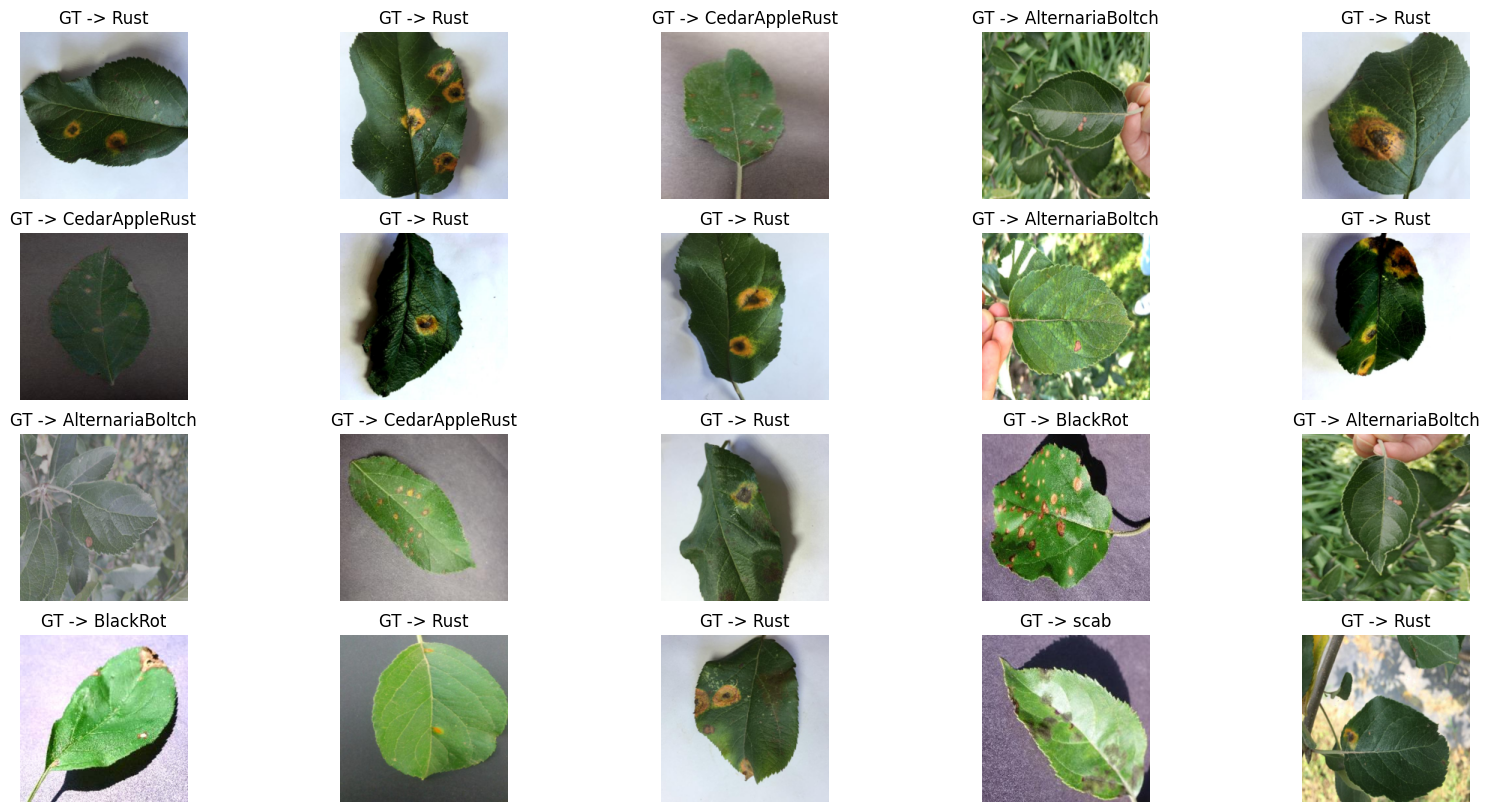

In [35]:
from utils import visualize
visualize(data = ds, rasmlar_soni = 20, qatorlar = 4, cmap = 'gray', klass_nomlari = klasslar)

In [37]:
import timm 

model = timm.create_model (model_name = "resnet18", pretrained = True , num_classes = len(klass_nomi))
model   

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [40]:
import torch
epochs = 10
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.train()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.001)

In [47]:
import numpy as np
from tqdm import tqdm

In [48]:
def train(model, tr_data, val_data, opt, loss_fn, device, epocs, threshold, save_prefix):
    tr_acc_sc, tr_epoc_loss, val_acc_sc, val_epoc_loss = [],[],[],[]
    best_loss = np.inf
    print("Train started ........")
    
    for epoc in range(epocs):
        print(f"{epoc+1} - epoch is started ...")
        tr_acc, tr_loss, tr_total =0,0,0
        for idx, batch in enumerate(tqdm(tr_data)):
            im, gt = batch
            im, gt = im.to(device), gt.to(device)
            tr_total+=im.shape[0]
            # predict using the model
            pred = model(im)
            # Culculate Loss using the loss function
            loss =loss_fn(pred, gt)
            #update the training loss 
            tr_loss+=loss.item()
            # get indeces of the maximum values in the predictions 
            pred_class = torch.argmax(pred, dim =1)
            # Culculate the train accurancy scores
            tr_acc+=(pred_class==gt).sum().item()

            # preform optimizetion steps
            
            opt.zero_grad()
            loss.backward()
            opt.step()
        tr_acc /=tr_total
        tr_loss /= len(tr_data)
        tr_acc_sc.append(tr_acc)
        tr_epoc_loss.append(tr_loss)

        # Validation progress
        # Set the model to evaluation mode
        model.eval()
        # Perform inference or validation without computing gradients
        with torch.no_grad():
            val_acc, val_loss, val_total =0,0,0
            for idx, batch in enumerate(tqdm(val_data)):
                im, gt = batch
                im, gt = im.to(device), gt.to(device)
                val_total+=im.shape[0]
                #predict using the model
                pred = model(im)
                # Culculate Loss using the loss function
                loss = loss_fn(pred, gt)
                # update validation loss
                val_loss+=loss.item()
                # get indeces of the maximum values in predictions
                pred_class =torch.argmax(pred, dim =1)
                # Culculate the validation accurancy scores
                val_acc+=(pred_class==gt).sum().item()
            
            val_acc /= val_total
            val_loss /=len(val_data)
            val_acc_sc.append(val_acc)
            val_epoc_loss.append(val_loss)
            
            print(f"{epoc+1} - Train epoch results:\n")
            print(f"{epoc+1} - Train Accurancy        - > {tr_acc:.3f}")
            print(f"{epoc+1} - Train epoch loss       - > {tr_loss:.3f}")
            print(f"{epoc+1} - Validation process  results:\n")
            print(f"{epoc+1} - Validation Accurancy score  - > {val_acc:.3f}")
            print(f"{epoc+1} - Validation epoc loss  score - > {val_loss:.3f}")
            
            if val_loss < (best_loss + threshold):
                val_loss = best_loss
                os.makedirs("apple_desease_best_model", exist_ok=True)
                torch.save(model, f"apple_desease_best_model/{save_prefix}_best_model.pht")
                
    return {"tr_acc_sc": tr_acc_sc, "tr_epoc_loss": tr_epoc_loss, "val_acc_sc": val_acc_sc, "val_epoc_loss": val_epoc_loss}

result = train(model= model.to(device), tr_data =tr_dl, val_data = val_dl, opt = optimizer, 
               loss_fn = loss_fn, device =device, epocs =10, threshold = 0.001, save_prefix = "apple_desease")

Train started ........
1 - epoch is started ...


100%|██████████| 18/18 [00:34<00:00,  1.89s/it]


1 - Train epoch results:

1 - Train Accurancy        - > 0.930
1 - Train epoch loss       - > 0.210
1 - Validation process  results:

1 - Validation Accurancy score  - > 0.981
1 - Validation epoc loss  score - > 0.044
2 - epoch is started ...


100%|██████████| 18/18 [00:29<00:00,  1.66s/it]


2 - Train epoch results:

2 - Train Accurancy        - > 0.938
2 - Train epoch loss       - > 0.184
2 - Validation process  results:

2 - Validation Accurancy score  - > 0.978
2 - Validation epoc loss  score - > 0.073
3 - epoch is started ...


100%|██████████| 18/18 [00:29<00:00,  1.65s/it]


3 - Train epoch results:

3 - Train Accurancy        - > 0.983
3 - Train epoch loss       - > 0.039
3 - Validation process  results:

3 - Validation Accurancy score  - > 0.984
3 - Validation epoc loss  score - > 0.034
4 - epoch is started ...


100%|██████████| 18/18 [00:30<00:00,  1.68s/it]


4 - Train epoch results:

4 - Train Accurancy        - > 0.984
4 - Train epoch loss       - > 0.035
4 - Validation process  results:

4 - Validation Accurancy score  - > 0.989
4 - Validation epoc loss  score - > 0.022
5 - epoch is started ...


100%|██████████| 18/18 [00:29<00:00,  1.66s/it]


5 - Train epoch results:

5 - Train Accurancy        - > 0.982
5 - Train epoch loss       - > 0.041
5 - Validation process  results:

5 - Validation Accurancy score  - > 0.985
5 - Validation epoc loss  score - > 0.024
6 - epoch is started ...


100%|██████████| 18/18 [00:29<00:00,  1.66s/it]


6 - Train epoch results:

6 - Train Accurancy        - > 0.988
6 - Train epoch loss       - > 0.021
6 - Validation process  results:

6 - Validation Accurancy score  - > 0.986
6 - Validation epoc loss  score - > 0.021
7 - epoch is started ...


100%|██████████| 18/18 [00:29<00:00,  1.67s/it]


7 - Train epoch results:

7 - Train Accurancy        - > 0.988
7 - Train epoch loss       - > 0.019
7 - Validation process  results:

7 - Validation Accurancy score  - > 0.985
7 - Validation epoc loss  score - > 0.054
8 - epoch is started ...


100%|██████████| 18/18 [00:34<00:00,  1.91s/it]


8 - Train epoch results:

8 - Train Accurancy        - > 0.987
8 - Train epoch loss       - > 0.020
8 - Validation process  results:

8 - Validation Accurancy score  - > 0.981
8 - Validation epoc loss  score - > 0.046
9 - epoch is started ...


100%|██████████| 18/18 [00:31<00:00,  1.76s/it]


9 - Train epoch results:

9 - Train Accurancy        - > 0.982
9 - Train epoch loss       - > 0.044
9 - Validation process  results:

9 - Validation Accurancy score  - > 0.977
9 - Validation epoc loss  score - > 0.054
10 - epoch is started ...


100%|██████████| 18/18 [00:30<00:00,  1.68s/it]

10 - Train epoch results:

10 - Train Accurancy        - > 0.980
10 - Train epoch loss       - > 0.047
10 - Validation process  results:

10 - Validation Accurancy score  - > 0.986
10 - Validation epoc loss  score - > 0.043


In [55]:
im, javob = next(iter(ts_dl))


model.eval ()
preds = []
images = []
lbls = []

for im, javob in zip(im, javob):
  rasm, javob = im.to(device), javob.to(device)
  # print(rasm.unsqueeze(0).shape)
  pred = model(im.unsqueeze(0))
  # print(pred.shape)
  pred_class = torch.argmax(pred, dim =1)
  images.append(im)
  lbls.append(javob)
  preds.append(pred_class)
# print(len(preds))

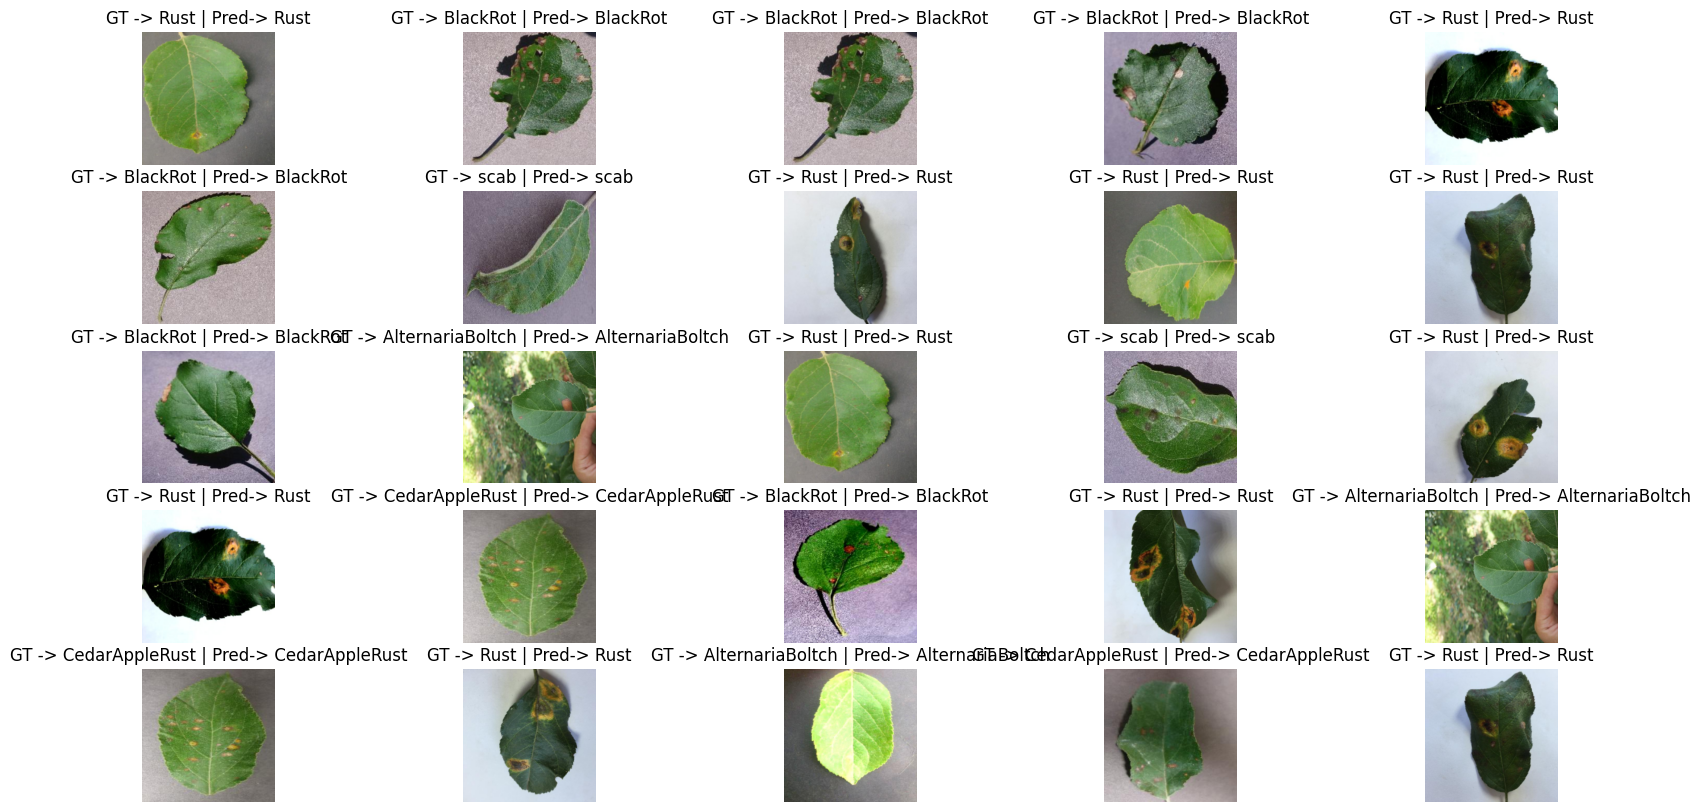

In [59]:
import random 
from utils import tensor_2_im 
from matplotlib import pyplot as plt 

num_im, row = 25, 5 

plt.figure(figsize=(20, 10))
indekslar = [random.randint(0, len(images) - 1) for _ in range(num_im)]

for i, indeks in enumerate(indekslar): 
    im = images[indeks]
    javob = klasslar[lbls[indeks]]  # Convert label to class name
    pred = klasslar[preds[indeks].item()]  # Convert prediction to class name
    
    plt.subplot(row, num_im // row, i + 1) 
    plt.imshow(tensor_2_im(im, t_type="gray"))
    plt.axis("off")
    plt.title(f"GT -> {javob} | Pred-> {pred}")

plt.show()

In [60]:
acc = 0
for ind, path in enumerate(ts_dl):
    im, gt = path
    im, gt = im.to(device), gt.to(device)
    pred = torch.argmax(model(im), dim=1)
    acc+=(pred==gt).sum().item()
print(f"Accuracy of the model on the test dataset is -> {(acc / len(ts_dl.dataset)):.3f}")

Accuracy of the model on the test dataset is -> 0.986


torch.Size([3, 224, 224])


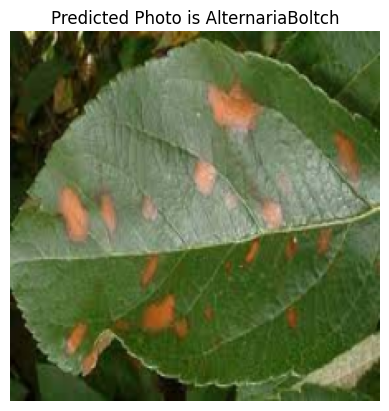

In [61]:
from PIL import Image
import torchvision.transforms as tfs
from matplotlib import pyplot as plt 
import numpy as np

rasm = Image.open("AlternariaBoltch.jpeg")

ts_ts = tfs.Compose([
    tfs.Resize((224, 224)),
    tfs.ToTensor(),
    tfs.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

tensor_im = ts_ts(rasm)
print(tensor_im.shape)


pred = model(tensor_im.unsqueeze(dim=0))
pred_class = torch.argmax(pred, dim=1)
plt.imshow(tensor_2_im(tensor_im, t_type="gray"))
plt.axis('off')
plt.title(f"Predicted Photo is {list(klass_nomi.keys())[pred_class.item()]}")
plt.show()


torch.Size([3, 224, 224])


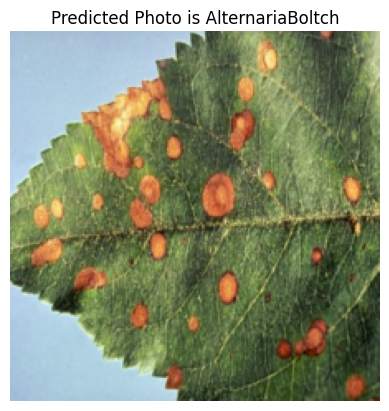

In [62]:
from PIL import Image
import torchvision.transforms as tfs
from matplotlib import pyplot as plt 
import numpy as np

rasm = Image.open("AlternariaBoltch2.jpeg")

ts_ts = tfs.Compose([
    tfs.Resize((224, 224)),
    tfs.ToTensor(),
    tfs.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

tensor_im = ts_ts(rasm)
print(tensor_im.shape)


pred = model(tensor_im.unsqueeze(dim=0))
pred_class = torch.argmax(pred, dim=1)
plt.imshow(tensor_2_im(tensor_im, t_type="gray"))
plt.axis('off')
plt.title(f"Predicted Photo is {list(klass_nomi.keys())[pred_class.item()]}")
plt.show()


torch.Size([3, 224, 224])


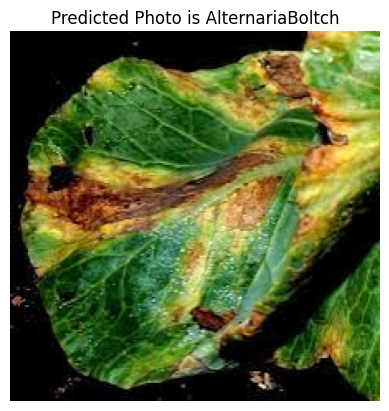

In [64]:
from PIL import Image
import torchvision.transforms as tfs
from matplotlib import pyplot as plt 
import numpy as np

rasm = Image.open("BlackRot1.jpeg")

ts_ts = tfs.Compose([
    tfs.Resize((224, 224)),
    tfs.ToTensor(),
    tfs.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

tensor_im = ts_ts(rasm)
print(tensor_im.shape)


pred = model(tensor_im.unsqueeze(dim=0))
pred_class = torch.argmax(pred, dim=1)
plt.imshow(tensor_2_im(tensor_im, t_type="gray"))
plt.axis('off')
plt.title(f"Predicted Photo is {list(klass_nomi.keys())[pred_class.item()]}")
plt.show()


torch.Size([3, 224, 224])


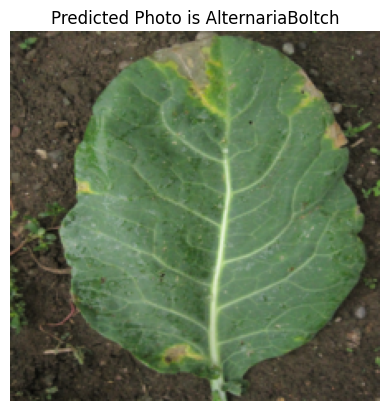

In [66]:
from PIL import Image
import torchvision.transforms as tfs
from matplotlib import pyplot as plt 
import numpy as np

rasm = Image.open("BlackRot2.jpg")

ts_ts = tfs.Compose([
    tfs.Resize((224, 224)),
    tfs.ToTensor(),
    tfs.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

tensor_im = ts_ts(rasm)
print(tensor_im.shape)


pred = model(tensor_im.unsqueeze(dim=0))
pred_class = torch.argmax(pred, dim=1)
plt.imshow(tensor_2_im(tensor_im, t_type="gray"))
plt.axis('off')
plt.title(f"Predicted Photo is {list(klass_nomi.keys())[pred_class.item()]}")
plt.show()
